In [0]:
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from skimage.transform import resize, rescale, rotate, setup, warp
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.patches as patches

from skimage.color import rgb2gray

import PIL
from PIL import Image

from google.colab import output

from sklearn.linear_model import LinearRegression

In [2]:
%cd /content/
if(os.path.isdir('/content/Lithuanian_OCR') == False):
  !git clone https://github.com/PauliusMilmantas/Lithuanian_OCR

/content
Cloning into 'Lithuanian_OCR'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3564 (delta 8), reused 29 (delta 4), pack-reused 3531
Receiving objects: 100% (3564/3564), 125.87 MiB | 31.79 MiB/s, done.
Resolving deltas: 100% (585/585), done.


In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, hidden3_size)
        self.relu3 = nn.ReLU()      
        self.fc4 = nn.Linear(hidden3_size, hidden4_size)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(hidden4_size, hidden5_size)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden5_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)        
        out = self.relu2(out)
        out = self.fc3(out)        
        out = self.relu3(out)
        out = self.fc4(out)        
        out = self.relu4(out)
        out = self.fc5(out)        
        out = self.relu5(out)
        out = self.fc6(out)
        return out

In [0]:
network = Net(4096, 2500, 1500, 500, 100, 50, 3)
network.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/model.pth'))
network.eval()

optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=0.6)
optimizer.load_state_dict(torch.load('/content/Lithuanian_OCR/Trained_model/optimizer.pth'))

criterion = nn.MSELoss()

In [0]:
def proccess_image(path):
  image = io.imread(path)
  image = rgb2gray(image)
  image = resize(image, (64, 64))
  
  return torch.tensor(image)

In [0]:
def get_max_from_tensor(data):
  maxVal = data[0]
  maxId = 0
  for i in range(len(data)):
    if(data[i] > maxVal):
      maxVal = data[i]
      maxId = i

  return maxId + 1

In [0]:
def get_result(data):
  idx = get_max_from_tensor(data) - 1

  if(data[idx] > 0 and data[idx] < 1):
    return idx + 1
  # No object found
  elif(data[idx] <= 0):
    return 0
  # Best guess is that there is no object
  else:
    return 0

In [0]:
def find_in_array(arr, element):
  idx = 0
  found = []

  for el in arr:
    if(el == element):
      found.append(idx)
    idx += 1

  return found

In [0]:
def find_probability(output, idx):
  output = output.detach().numpy()
  probability = output[idx]
  for i in range(len(output)):
    if i != idx:
      probability -= output[i]
  return probability

In [0]:
def prepare_image_for_network(image):
  image = resize(image, (64, 64))

  return image

In [0]:
def clasifier(data):
  newData = []
  
  for dt in data:
    if(dt == 1):
      newData.append("A")
    elif(dt == 2):
      newData.append("B")
    elif(dt == 3):
      newData.append("C")
    else:
      newData.append(dt)

  return newData

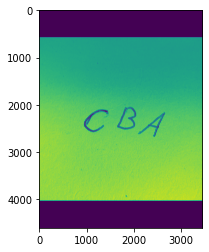

In [15]:
image = io.imread('/content/Lithuanian_OCR/Examples/example2.jpg')

image = rotate(image, 90)
image = rgb2gray(image)
plt.imshow(image)

Searching color distances...
Sorting by y...
Removing far point by x axis
Sorting by x...
Removing far point by x axis


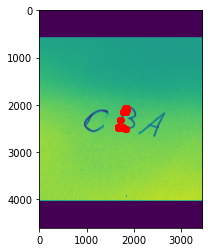

44


In [16]:
registered_x = []
registered_y = []

print("Searching color distances...")
for y in range(image.shape[0]):
  last_val = image[y][0]
  for x in range(image.shape[1]):
    if(abs(last_val - image[y][x]) >= 0.1):
      registered_x.append(x)
      registered_y.append(y)
    last_val = image[y][x]

# Sorting points by y
print("Sorting by y...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_y)-1):
    if(registered_y[i] > registered_y[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_y)-1):
    if(i != len(registered_y)-1):
      if(abs(registered_y[i+1] - registered_y[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_y[i] - registered_y[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y
  
# Sorting points by x
print("Sorting by x...")
sorted = False
while(sorted == False):
  sorted = True
  for i in range(len(registered_x)-1):
    if(registered_x[i] > registered_x[i+1]):
      sorted = False
      buffX = registered_x[i]
      buffY = registered_y[i]

      registered_x[i] = registered_x[i+1]
      registered_y[i] = registered_y[i+1]

      registered_x[i+1] = buffX
      registered_y[i+1] = buffY

# Filter points that are far away from each other
print("Removing far point by x axis")
removed = True
while(removed == True):
  removed = False
  buffer_x = []
  buffer_y = []
  distance_treshold = 200
  for i in range(len(registered_x)-1):
    if(i != len(registered_x)-1):
      if(abs(registered_x[i+1] - registered_x[i]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True
    else:
      if(abs(registered_x[i] - registered_x[i-1]) < distance_treshold):
        buffer_x.append(registered_x[i])
        buffer_y.append(registered_y[i])
      else:
        removed = True

  registered_x = buffer_x
  registered_y = buffer_y

implot = plt.imshow(image)
plt.scatter(registered_x, registered_y, c='r')
plt.show()

print(len(registered_x))

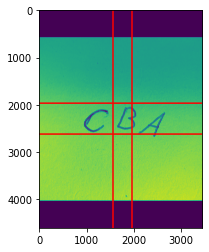

In [17]:
margins = 100

# Finding lowest y point
lowest_y = registered_y[0]
lowest_x = registered_x[0]

highest_y = registered_y[0]
highest_x = registered_x[0]

for i in range(len(registered_x)):
  if(registered_y[i] > highest_y):
    highest_x = registered_x[i]
    highest_y = registered_y[i]

  if(registered_y[i] < lowest_y):
    lowest_x = registered_x[i]
    lowest_y = registered_y[i]

# Finding smallest x point
smallest_x = registered_x[0]
smallest_y = registered_y[0]

biggest_x = registered_x[0]
biggest_y = registered_y[0]

for i in range(len(registered_x)):
  if(registered_x[i] > biggest_x):
    biggest_x = registered_x[i]
    biggest_y = registered_y[i]

  if(registered_x[i] < smallest_x):
    smallest_x = registered_x[i]
    smallest_y = registered_y[i]

implot = plt.imshow(image)
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(highest_y+margins, image.shape[1]), c='r')
plt.plot(np.arange(0, image.shape[1], 1), np.repeat(lowest_y-margins, image.shape[1]), c='r')
plt.axvline(smallest_x-margins, c='r')
plt.axvline(biggest_x+margins, c='r')
plt.show()

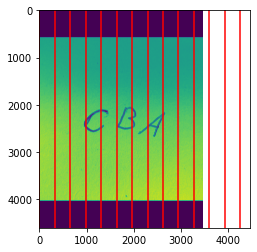

In [18]:
use_y_restriction = False
height = highest_y - lowest_y + margins * 2

# Starting points for reading image

implot = plt.imshow(image)
for i in range(int(image.shape[0]/(height/2))):
  plt.axvline(i*(height/2), c='r')
plt.show()

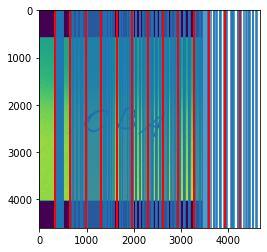

164


In [19]:
# Checking image coverage
stepSize = 5

counter = 0
implot = plt.imshow(image)

for i in range(int(image.shape[0]/(height/2))):
  for m in range(int(image.shape[0]/(height/2))):
    if(i * (height/2) + m * i * int(image.shape[0]/(height/2)) <= image.shape[0]):
      plt.axvline(i*(height/2), c='r')
      plt.axvline(i * (height/2) + m * i * int(image.shape[0]/(height/2)))
      counter += 1
plt.show()
print(counter)

In [20]:
score_treshold = 0.75
letters = []

for i in range(int(image.shape[0]/(height/2))):
  maxProb = 0
  gotRes = 0

  for m in range(int((height/2)/stepSize)):
    img = image[int(i*(height/2)):int((i+1)*(height/2) + m * (height/2)/stepSize), lowest_y-margins:highest_y+margins]

    output = network(torch.Tensor(prepare_image_for_network(img).flatten()).float())
    res = get_result(output)

    prob = find_probability(output, res-1)
    if(prob > score_treshold):
      if(prob > maxProb):
        maxProb = prob
        gotRes = res

  if(maxProb != 0):
    print("Found: {} Prob: {}".format(gotRes, maxProb))
    i += 1
    letters.append(gotRes)

Found: 1 Prob: 0.8109958171844482
Found: 1 Prob: 0.7989426255226135
Found: 1 Prob: 0.8532081246376038
Found: 1 Prob: 0.893506646156311
Found: 1 Prob: 0.9261339902877808
Found: 1 Prob: 0.9423034191131592
Found: 1 Prob: 0.9489402770996094
Found: 1 Prob: 0.965022623538971
Found: 1 Prob: 0.9844373464584351
Found: 2 Prob: 0.8886902332305908
Found: 2 Prob: 0.9191570281982422


In [25]:
# Removing duplicates from array
answer = []
last_letter = ""
for x in letters:
  if last_letter == "":
    last_letter = x
    answer.append(x)
  else:
    if(x != last_letter):
      last_letter = x
      answer.append(x)

print(clasifier(answer))

['A', 'B']
